In [1]:
import cirq 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from cirq.contrib.svg import SVGCircuit
import sympy
import scipy

In [2]:
def generalized_sigma(index, i, j, dimension=4):
    """Generalized sigma matrix for qudit gates implementation"""

    sigma = np.zeros((dimension, dimension), dtype='complex')

    if index == 0:
        # identity matrix elements
        sigma[i][i] = 1
        sigma[j][j] = 1
    elif index == 1:
        # sigma_x matrix elements
        sigma[i][j] = 1
        sigma[j][i] = 1
    elif index == 2:
        # sigma_y matrix elements
        sigma[i][j] = -1j
        sigma[j][i] = 1j
    elif index == 3:
        # sigma_z matrix elements
        sigma[i][i] = 1
        sigma[j][j] = -1

    return sigma

class QuditGate(cirq.Gate):
    def __init__(self, dimension=4, num_qubits=1):
        self.d = dimension
        self.n = num_qubits
        self.symbol = None

    def _num_qubits_(self):
        return self.n

    def _qid_shape_(self):
        return (self.d,) * self.n

    def _circuit_diagram_info_(self, args):
        return (self.symbol,) * self.n

In [3]:
class QuquartH(QuditGate):
    def __init_(self):
        super().__init__(dimension=4, num_qubits=1)
        
    def _unitary_(self):
        return (1 / np.sqrt(2)) * np.array([[1, 1, 0, 0],
                              [1, -1, 0, 0],
                              [0, 0, 0, 0],
                              [0, 0, 0, 0]])
    
    def _circuit_diagram_info_(self, args):
        return "[H4]"

class QuditZZGate(QuditGate):
    def __init__(self, l1, l2, theta, dimension=4):
        super().__init__(dimension=dimension, num_qubits=2)
        self.l1 = l1
        self.l2 = l2
        self.theta = theta

    def _unitary_(self):
        sigma_z = generalized_sigma(3, self.l1, self.l2, dimension=self.d)
        
        u = scipy.linalg.expm(-1j * self.theta / 2 * np.kron(sigma_z, sigma_z))

        return u

    def _is_parameterized_(self) -> bool:
        return cirq.protocols.is_parameterized(self.theta)

    def _resolve_parameters_(self, resolver: 'cirq.ParamResolver', recursive: bool):
        return self.__class__(self.l1, self.l2, resolver.value_of(self.theta, recursive), dimension=self.d)

    def _circuit_diagram_info_(self, args):
        return f"ZZ^{self.theta}", f"ZZ^{self.theta}"
    

class QuditXGate(QuditGate):
    def __init__(self, l1, l2, theta, dimension=4):
        super().__init__(dimension=dimension, num_qubits=1)
        self.l1 = l1
        self.l2 = l2
        self.theta = theta

    def _unitary_(self):
        sigma_x = generalized_sigma(1, self.l1, self.l2, dimension=self.d)
        
        u = scipy.linalg.expm(-1j * self.theta / 2 * sigma_x)

        return u

    def _is_parameterized_(self) -> bool:
        return cirq.protocols.is_parameterized(self.theta)

    def _resolve_parameters_(self, resolver: 'cirq.ParamResolver', recursive: bool):
        return self.__class__(self.l1, self.l2, resolver.value_of(self.theta, recursive), dimension=self.d)

    def _circuit_diagram_info_(self, args):
        return f"X^{self.theta}"
    



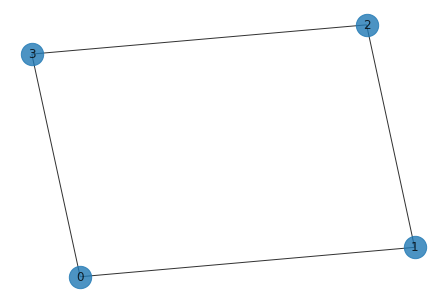

In [4]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)


In [5]:
nx.set_edge_attributes(
    G,
#     {e: {"weight": np.random.randint(0, 500) / 100} for e in G.edges},
    {e: {"weight": 1} for e in G.edges}
)


In [6]:
def estimate_cost(G, measurements) -> float:
    cost_value = 0.0

    
    for u, v, w in G.edges(data=True):
        u_samples = measurements[f"q({u}) (d=4)"]
        v_samples = measurements[f"q({v}) (d=4)"]
        
        u_signs = (-1) ** u_samples
        v_signs = (-1) ** v_samples
        
        term_signs = u_signs * v_signs
        term_val = np.mean(term_signs) * w["weight"]
        cost_value += term_val
    return cost_value

In [7]:
def function_for_minimize(data):
    alpha_in = data[0]
    beta_in = data[1]
    alpha = sympy.Symbol("alpha")
    beta = sympy.Symbol("beta")

    qudits = cirq.LineQid.range(len(G.nodes), dimension=4)

    qaoa_circuit = cirq.Circuit(
        (QuquartH().on(qudit) for qudit in qudits),

        (
            QuditZZGate(0, 1, alpha * w["weight"]).on(qudits[u], qudits[v])
            for (u, v, w) in G.edges(data=True)
        ),
        cirq.Moment(QuditXGate(0, 1, beta).on(qudit) for qudit in qudits),

        (cirq.measure(qudit) for qudit in qudits),
    )
    sim = cirq.Simulator()
    sample_results = sim.sample(
        qaoa_circuit, params={alpha: alpha_in, beta: beta_in}, repetitions=1000
    )
    SVGCircuit(qaoa_circuit)
    return estimate_cost(G, sample_results), data

In [8]:

alpha = []
beta = []
alpha_sweep = np.linspace(0, 50, 100)
beta_sweep = np.linspace(0, 50, 100)
params = np.transpose([np.tile(alpha_sweep, len(beta_sweep)), np.repeat(beta_sweep, len(alpha_sweep))])
results = []

for i, param in enumerate(params):
    results.append(function_for_minimize(param)[0])
print(params[results.index(min(results))])
best_params = params[results.index(min(results))]

[ 8.58585859 47.97979798]


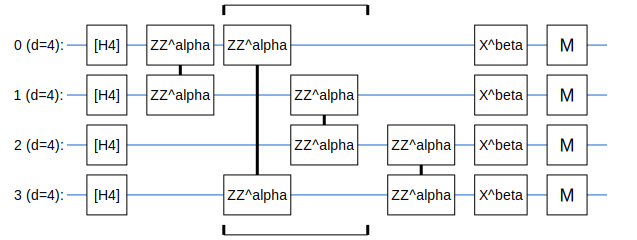

In [9]:
import pandas as pd
alpha_in = best_params[0]
beta_in = best_params[1]
alpha = sympy.Symbol("alpha")
beta = sympy.Symbol("beta")

qudits = cirq.LineQid.range(len(G.nodes), dimension=4)

qaoa_circuit = cirq.Circuit(
    (QuquartH().on(qudit) for qudit in qudits),

    (
        QuditZZGate(0, 1, alpha * w["weight"]).on(qudits[u], qudits[v])
        for (u, v, w) in G.edges(data=True)
    ),
    cirq.Moment(QuditXGate(0, 1, beta).on(qudit) for qudit in qudits),

    (cirq.measure(qudit) for qudit in qudits),
)
sim = cirq.Simulator()
sample_results = sim.sample(
    qaoa_circuit, params={alpha: alpha_in, beta: beta_in}, repetitions=20_000
)
SVGCircuit(qaoa_circuit)



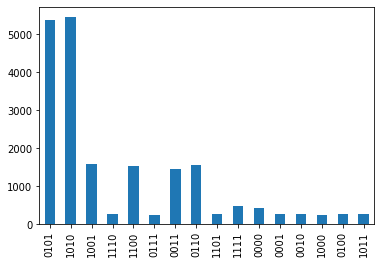

In [10]:
result_strs = []
for i in range(len(sample_results)):
    one_result = sample_results.iloc[[i]]
    result_str = str(one_result[f"q({0}) (d=4)"].to_numpy()[0]) + str(one_result[f"q({1}) (d=4)"].to_numpy()[0]) + str(one_result[f"q({2}) (d=4)"].to_numpy()[0]) + str(one_result[f"q({3}) (d=4)"].to_numpy()[0])
    result_strs.append(result_str)
pd.Series(result_strs).value_counts(sort=False).plot(kind='bar')